# HSDN Network Project: Sidhant Puntambekar, Behzod Mirpochoev

In [1]:
!git submodule update

In [2]:
!sh scripts/compile_engines.sh
#!cd bipartiteSBM/engines/bipartiteSBM-KL/ && pwd && ls -l

CMake Deprecation Warning at CMakeLists.txt:4 (cmake_minimum_required):
  Compatibility with CMake < 2.8.12 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value or use a ...<max> suffix to tell
  CMake that the project does not need compatibility with older versions.


-- Performing Test HAVE_STEADY_CLOCK
-- Performing Test HAVE_STEADY_CLOCK -- success
-- Configuring done
-- Generating done
-- Build files have been written to: /Users/Admin/CSCI-3352/3352_project/network/bipartiteSBM/engines/bipartiteSBM-MCMC
Consolidate compiler generated dependencies of target mcmc
[100%] Built target mcmc
/Users/Admin/CSCI-3352/3352_project/network/bipartiteSBM
/Users/Admin/CSCI-3352/3352_project/network/bipartiteSBM


In [3]:
!python3 -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import networkx as nx
from networkx.algorithms import bipartite

import numpy as np
import matplotlib
import matplotlib.pylab as plt
import matplotlib.cm as cm
import random
import copy
import pandas as pd

import biSBM as bm

# Kernighan-Lin inference
from engines.kl import *
from biSBM.ioutils import get_types

# MCMC inference
from biSBM.ioutils import get_edgelist, get_types
from biSBM.optimalks import *
from engines.mcmc import *

# Louvain clustering
import community as community_louvain

%matplotlib inline

In [5]:
# %load bipartiteSBM/tests/test_kl.py
import biSBM as bm


kl = bm.engines.KL(
    f_engine="engines/bipartiteSBM-KL/biSBM",
    n_sweeps=1,
    is_parallel=True,
    n_cores=1,
    kl_edgelist_delimiter="\t",
    kl_steps=5,
    kl_itertimes=1,
    f_kl_output="engines/bipartiteSBM-KL/f_kl_output"
)

edgelist = bm.get_edgelist("dataset/test/southernWomen.edgelist", "\t")
types = bm.get_types("dataset/test/southernWomen.types")

oks = bm.OptimalKs(kl, edgelist, types, default_args=True, random_init_k=False)


def test_answer():
    oks.minimize_bisbm_dl()
    ka = oks.summary()["ka"]
    kb = oks.summary()["kb"]
    assert (ka, kb) == (1, 1)  # there exists no community structure in the southernWomen dataset

test_answer()

# Utility Functions

In [6]:
# Plot CCDF from PS5
def plot_CCDF(kis):
    # from PS5
    # input : a list of degrees, e.g., from a networkx graph G
    # output: a plot of the CCDF of the degree distribution Pr(K>=k) for k>=1
    
    kmax = max(kis)

    # histogram and plot
    counts, bins = np.histogram(kis, bins=[i for i in range(kmax+2)], density=True)
    cumcounts = np.cumsum(counts)
    cumcounts = np.insert(cumcounts,0,0)
    plt.loglog(bins[1:-1], 1-cumcounts[1:-1], 'rs', alpha=0.5)
    plt.xlabel('Degree, k')
    plt.ylabel('Pr(K>=k)')
    plt.show()
    return

In [7]:
def compute_MGD(G):
    # from PS3
    # input : a networkx graph G
    # output: the mean geodesic path length (defined in Lecture 2)

    dij = dict(nx.all_pairs_shortest_path_length(G)) # APSP on G, store as a dictionary (tricky :)

    ells = []                            # list of non-zero and non-infinite lengths
    for node in dij:                     # loop over all the nodes
        temp = list(dij[node].values())  #   get the list of distances
        for length in temp:              #     for each of those distances
            if length>0:                 #     ignore if =0
                ells.append(length)      #     otherwise, add it to ells
                
    ellmean = np.mean(ells)              # MGD = numpy mean of ells list
    return ellmean

In [8]:
def draw_G(G):
    # input : a networkx graph G
    # output: a spring-plot of the network

    print(f'graph with n={G.order()} nodes and m={G.size()} edges:')
    nx.draw_networkx(G,with_labels=True,node_size=600,width=2) # draw it pretty
    limits=plt.axis('off')                                     # turn off axes
    plt.show()
    return

In [9]:
def drawGz(G,z):
    # input  : a graph G and a partition dictionary z
    # output : prints a graph with colored nodes corresponding to groups
    
    colors = ['#d61111','#11c6d6','#d67711','#11d646','#1b11d6','#d611cc'] # map node labels to colors (for the visualization)
    node_colors = []
    for i in G.nodes():
        node_colors.append(colors[int(z[i])])
    nsize  = 600
    flabel = True
    if G.order() > 50:
        nsize  = 100
        flabel = False   
    nx.draw_networkx(G,with_labels=flabel,node_size=nsize,width=2,node_color=node_colors) # draw it pretty
    limits=plt.axis('off')                                      # turn off axes
    plt.show() 

    return

# Read In Network and Data Quality Control 

In [10]:
# Read in disease only data 

fname1 = 'sup1.txt'

dfDisease = pd.read_csv(fname1, sep = '\t')
dfDisease

MeSH Disease Term  PubMed occurrence
0                    Breast Neoplasms             122226
1                        Hypertension             107294
2             Coronary Artery Disease              82819
3                      Lung Neoplasms              78009
4               Myocardial Infarction              75945
...                               ...                ...
4437  Mannosidase Deficiency Diseases                  1
4438             White Heifer Disease                  1
4439                        Tetrasomy                  1
4440                    Milk Sickness                  1
4441    Intrauterine Device Migration                  1

[4442 rows x 2 columns]

In [11]:
# Read in symptom only data 

fname2 = 'sup2.txt'

dfSymptom = pd.read_csv(fname2, sep = '\t')
dfSymptom

MeSH Symptom Term  PubMed occurrence
0                                  Body Weight             147857
1                                         Pain             103168
2                                      Obesity             100301
3                                       Anoxia              47351
4                           Mental Retardation              43883
..                                         ...                ...
317                        Alien Hand Syndrome                 10
318              Necrolytic Migratory Erythema                  7
319                        Body Weight Changes                  4
320                    Slit Ventricle Syndrome                  3
321  Infantile Apparent Life-Threatening Event                  2

[322 rows x 2 columns]

In [12]:
# Read in disease-symptom data 

fname3 = 'sup3.txt'

dfHSDN = pd.read_csv(fname3, sep = '\t')
dfHSDN

MeSH Symptom Term                       MeSH Disease Term  \
0       Aging, Premature  Respiratory Syncytial Virus Infections   
1       Aging, Premature             Orthomyxoviridae Infections   
2       Aging, Premature                          HIV Infections   
3       Aging, Premature      Acquired Immunodeficiency Syndrome   
4       Aging, Premature                        Breast Neoplasms   
...                  ...                                     ...   
147973         Hirsutism                    Tobacco Use Disorder   
147974         Hirsutism                        Radius Fractures   
147975         Hirsutism                                   Burns   
147976         Hirsutism                        Colles' Fracture   
147977         Hirsutism                      Radiation Injuries   

        PubMed occurrence  TFIDF score  
0                       1     3.464551  
1                       1     3.464551  
2                       3    10.393654  
3                       3    10.393654  
4                       1     3.464551  
...                   ...          ...  
147973                  1     2.483722  
147974                  1     2.483722  
147975                  1     2.483722  
147976                  1     2.483722  
147977                  1     2.483722  

[147978 rows x 4 columns]

In [13]:
# Read in significant shared symptoms and shared genes/PPIs data

fname4 = 'sup4.txt'

dfPPI = pd.read_csv(fname4, sep = '\t')
dfPPI

MeSH Disease Term  \
0            Histiocytoma, Benign Fibrous   
1            Histiocytoma, Benign Fibrous   
2                 Arthropathy, Neurogenic   
3                 Arthropathy, Neurogenic   
4       Hemangioendothelioma, Epithelioid   
...                                   ...   
133101                             Myopia   
133102                             Myopia   
133103                     IgA Deficiency   
133104                     IgA Deficiency   
133105                        Torticollis   

                            MeSH Disease Term.1  symptom similarity score  
0                                      Aneurysm                  0.591937  
1                         Carcinoma, Basal Cell                  0.310479  
2               Corneal Dystrophies, Hereditary                  0.133123  
3                  Foot Deformities, Congenital                  0.156900  
4                             Thyroid Neoplasms                  0.157077  
...                                         ...                       ...  
133101                            Hypotrichosis                  0.140889  
133102                     Vitamin A Deficiency                  0.199410  
133103                        Intestinal Polyps                  0.142195  
133104  Autoimmune Lymphoproliferative Syndrome                  0.561311  
133105                           Cryptorchidism                  0.104462  

[133106 rows x 3 columns]

Text(0, 0.5, 'PubMed occurence')

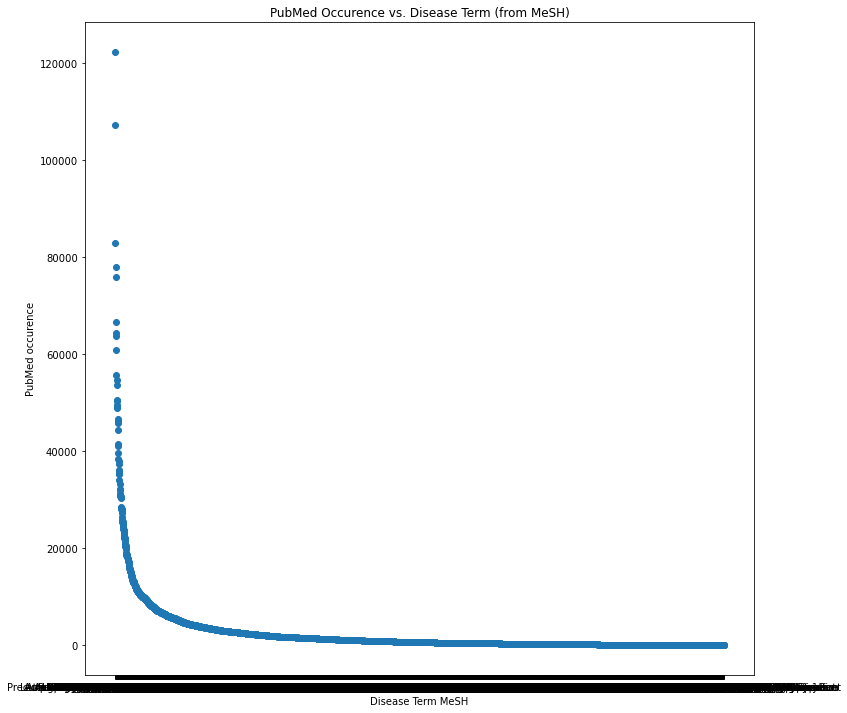

In [14]:
# PubMed occurence vs. disease name

plt.figure(figsize=(12,12))
plt.scatter(dfDisease["MeSH Disease Term"], dfDisease["PubMed occurrence"])

plt.title("PubMed Occurence vs. Disease Term (from MeSH)")
plt.xlabel("Disease Term MeSH")
plt.ylabel("PubMed occurence")

Text(0, 0.5, 'PubMed occurence')

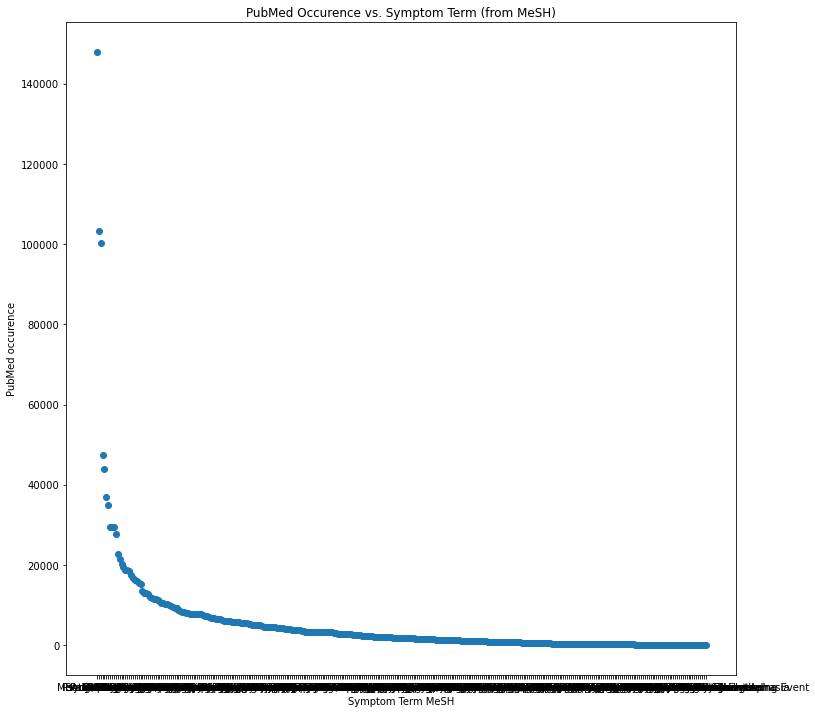

In [15]:
# PubMed occurence vs. symptom name

plt.figure(figsize=(12,12))
plt.scatter(dfSymptom["MeSH Symptom Term"], dfSymptom["PubMed occurrence"])
plt.title("PubMed Occurence vs. Symptom Term (from MeSH)")
plt.xlabel("Symptom Term MeSH")
plt.ylabel("PubMed occurence")

# Bipartite Network

In [16]:
# Isolate Symptom and Disease term
dfHSDN = dfHSDN[dfHSDN["PubMed occurrence"] >= 150]
dfHSDN = dfHSDN[dfHSDN["MeSH Symptom Term"]!=dfHSDN["MeSH Disease Term"]]
dfHSDNEdges = dfHSDN.reindex(columns=["MeSH Symptom Term","MeSH Disease Term"])
dfHSDNEdges

MeSH Symptom Term                MeSH Disease Term
668                            Fever             Bacterial Infections
669                            Fever                       Bacteremia
816                            Fever        Staphylococcal Infections
837                            Fever                        Infection
869                            Fever                           Sepsis
...                              ...                              ...
147273  Urinary Incontinence, Stress      Postoperative Complications
147461                      Virilism                Ovarian Neoplasms
147530                      Virilism  Adrenal Hyperplasia, Congenital
147641                     Hirsutism        Polycystic Ovary Syndrome
147895                     Hirsutism                   Hypertrichosis

[965 rows x 2 columns]

In [17]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

part0 = dfHSDNEdges['MeSH Symptom Term'].unique()
part1 = dfHSDNEdges['MeSH Disease Term'].unique()

# Find common symptoms - disseases, not useful 
comm = intersection(part0, part1)
print(len(comm))

# Remove the rows that are in comm
dfHSDNEdges = dfHSDNEdges[~dfHSDNEdges['MeSH Symptom Term'].isin(comm)]

# Delete duplicate rows
dfHSDNEdges_ = dfHSDNEdges.drop_duplicates(subset=["MeSH Symptom Term","MeSH Disease Term"], keep=False)
dfHSDNEdges_

69


MeSH Symptom Term                MeSH Disease Term
668                            Fever             Bacterial Infections
669                            Fever                       Bacteremia
816                            Fever        Staphylococcal Infections
837                            Fever                        Infection
869                            Fever                           Sepsis
...                              ...                              ...
147273  Urinary Incontinence, Stress      Postoperative Complications
147461                      Virilism                Ovarian Neoplasms
147530                      Virilism  Adrenal Hyperplasia, Congenital
147641                     Hirsutism        Polycystic Ovary Syndrome
147895                     Hirsutism                   Hypertrichosis

[433 rows x 2 columns]

In [18]:
# Get unique symptoms

dfUniqueSymptoms = dfHSDNEdges['MeSH Symptom Term'].unique()
len(dfUniqueSymptoms)

102

In [19]:
# Get unique diseases

dfUniqueDiseases = dfHSDNEdges['MeSH Disease Term'].unique()
len(dfUniqueDiseases)

262

In [20]:
# Join each disease to each symptom it is associated with in a tuple

listSymptomDiseaseJoin = list(dfHSDNEdges.to_records(index = False))
print(listSymptomDiseaseJoin)

[('Fever', 'Bacterial Infections'), ('Fever', 'Bacteremia'), ('Fever', 'Staphylococcal Infections'), ('Fever', 'Infection'), ('Fever', 'Sepsis'), ('Fever', 'Urinary Tract Infections'), ('Fever', 'Common Cold'), ('Fever', 'HIV Infections'), ('Fever', 'Malaria'), ('Fever', 'Malaria, Falciparum'), ('Fever', 'Leukemia'), ('Fever', 'Pneumonia'), ('Fever', 'Seizures'), ('Fever', 'Pain'), ('Fever', 'Agranulocytosis'), ('Fever', 'Neutropenia'), ('Fever', 'Skin Diseases'), ('Fever', 'Drug Hypersensitivity'), ('Fever', 'Inflammation'), ('Fever', 'Postoperative Complications'), ('Fever of Unknown Origin', 'Neutropenia'), ('Hypothermia', 'Heart Arrest'), ('Body Weight', 'HIV Infections'), ('Body Weight', 'Polycystic Ovary Syndrome'), ('Body Weight', 'Adenocarcinoma'), ('Body Weight', 'Breast Neoplasms'), ('Body Weight', 'Colonic Neoplasms'), ('Body Weight', 'Liver Neoplasms'), ('Body Weight', 'Liver Neoplasms, Experimental'), ('Body Weight', 'Pancreatic Neoplasms'), ('Body Weight', 'Mammary Neopla

In [21]:
# Create bipartite network with symptoms in one set, diseases in other set, join with edge list

GHSDNBipartite = nx.Graph()
GHSDNBipartite.add_nodes_from(dfUniqueSymptoms, bipartite = 0)
GHSDNBipartite.add_nodes_from(dfUniqueDiseases, bipartite = 1)
GHSDNBipartite.add_edges_from(listSymptomDiseaseJoin)

In [22]:
# Taking the largest connected component
components = sorted(nx.connected_components(GHSDNBipartite), key=len, reverse=True)
largestComponent = components[0]
GHSDNBipartiteII = GHSDNBipartite.subgraph(largestComponent)

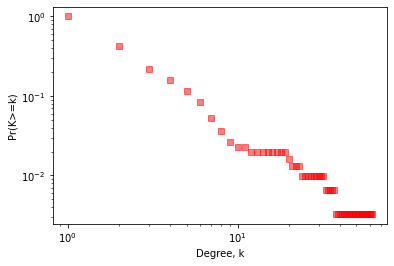

number of nodes, n  = 364
number of edges, m  = 433
diameter = 15
mean geodesic distance, <ell> =  4.80
clustering coefficient, C     =  0.00
number of components,   h     =  1
mean degree, k_mean = 2.379120879120879
max degree, k_max = 62
max degree, k_std =  4.96


In [23]:
n = GHSDNBipartite.number_of_nodes()
m = GHSDNBipartite.number_of_edges()

# Calculate summary statistics. Network is disconnected it seems like so should we instead to edge prediction?

diameter = nx.diameter(GHSDNBipartiteII)
ellmean = compute_MGD(GHSDNBipartiteII)
C = nx.transitivity(GHSDNBipartiteII) 
h = nx.number_connected_components(GHSDNBipartiteII)
degrees = [i[1] for i in GHSDNBipartiteII.degree()]
kmean = (2*m) / n
kmax = max(degrees)
kstd = np.std(degrees)

plot_CCDF(degrees) # Call plot_CCDF on degrees list

print(f'number of nodes, n  = {n}')
print(f'number of edges, m  = {m}') # 4802 missing edges?
print(f'diameter = {diameter}')
print(f'mean geodesic distance, <ell> = %5.2f' % ellmean)
print(f'clustering coefficient, C     = %5.2f' % C)
print(f'number of components,   h     =  {h}')
print(f'mean degree, k_mean = {kmean}')
print(f'max degree, k_max = {kmax}')
print(f'max degree, k_std = %5.2f' % kstd)

In [24]:
nx.is_connected(GHSDNBipartiteII)
print(nx.number_connected_components(GHSDNBipartiteII))

print([len(c) for c in sorted(nx.connected_components(GHSDNBipartiteII), key=len, reverse=True)])

1
[306]


In [25]:
# for component in list(nx.connected_components(GHSDNBipartiteII)):
#     if len(component) < 3:
#         for node in component:
#             GHSDNBipartiteII.remove_node(node)

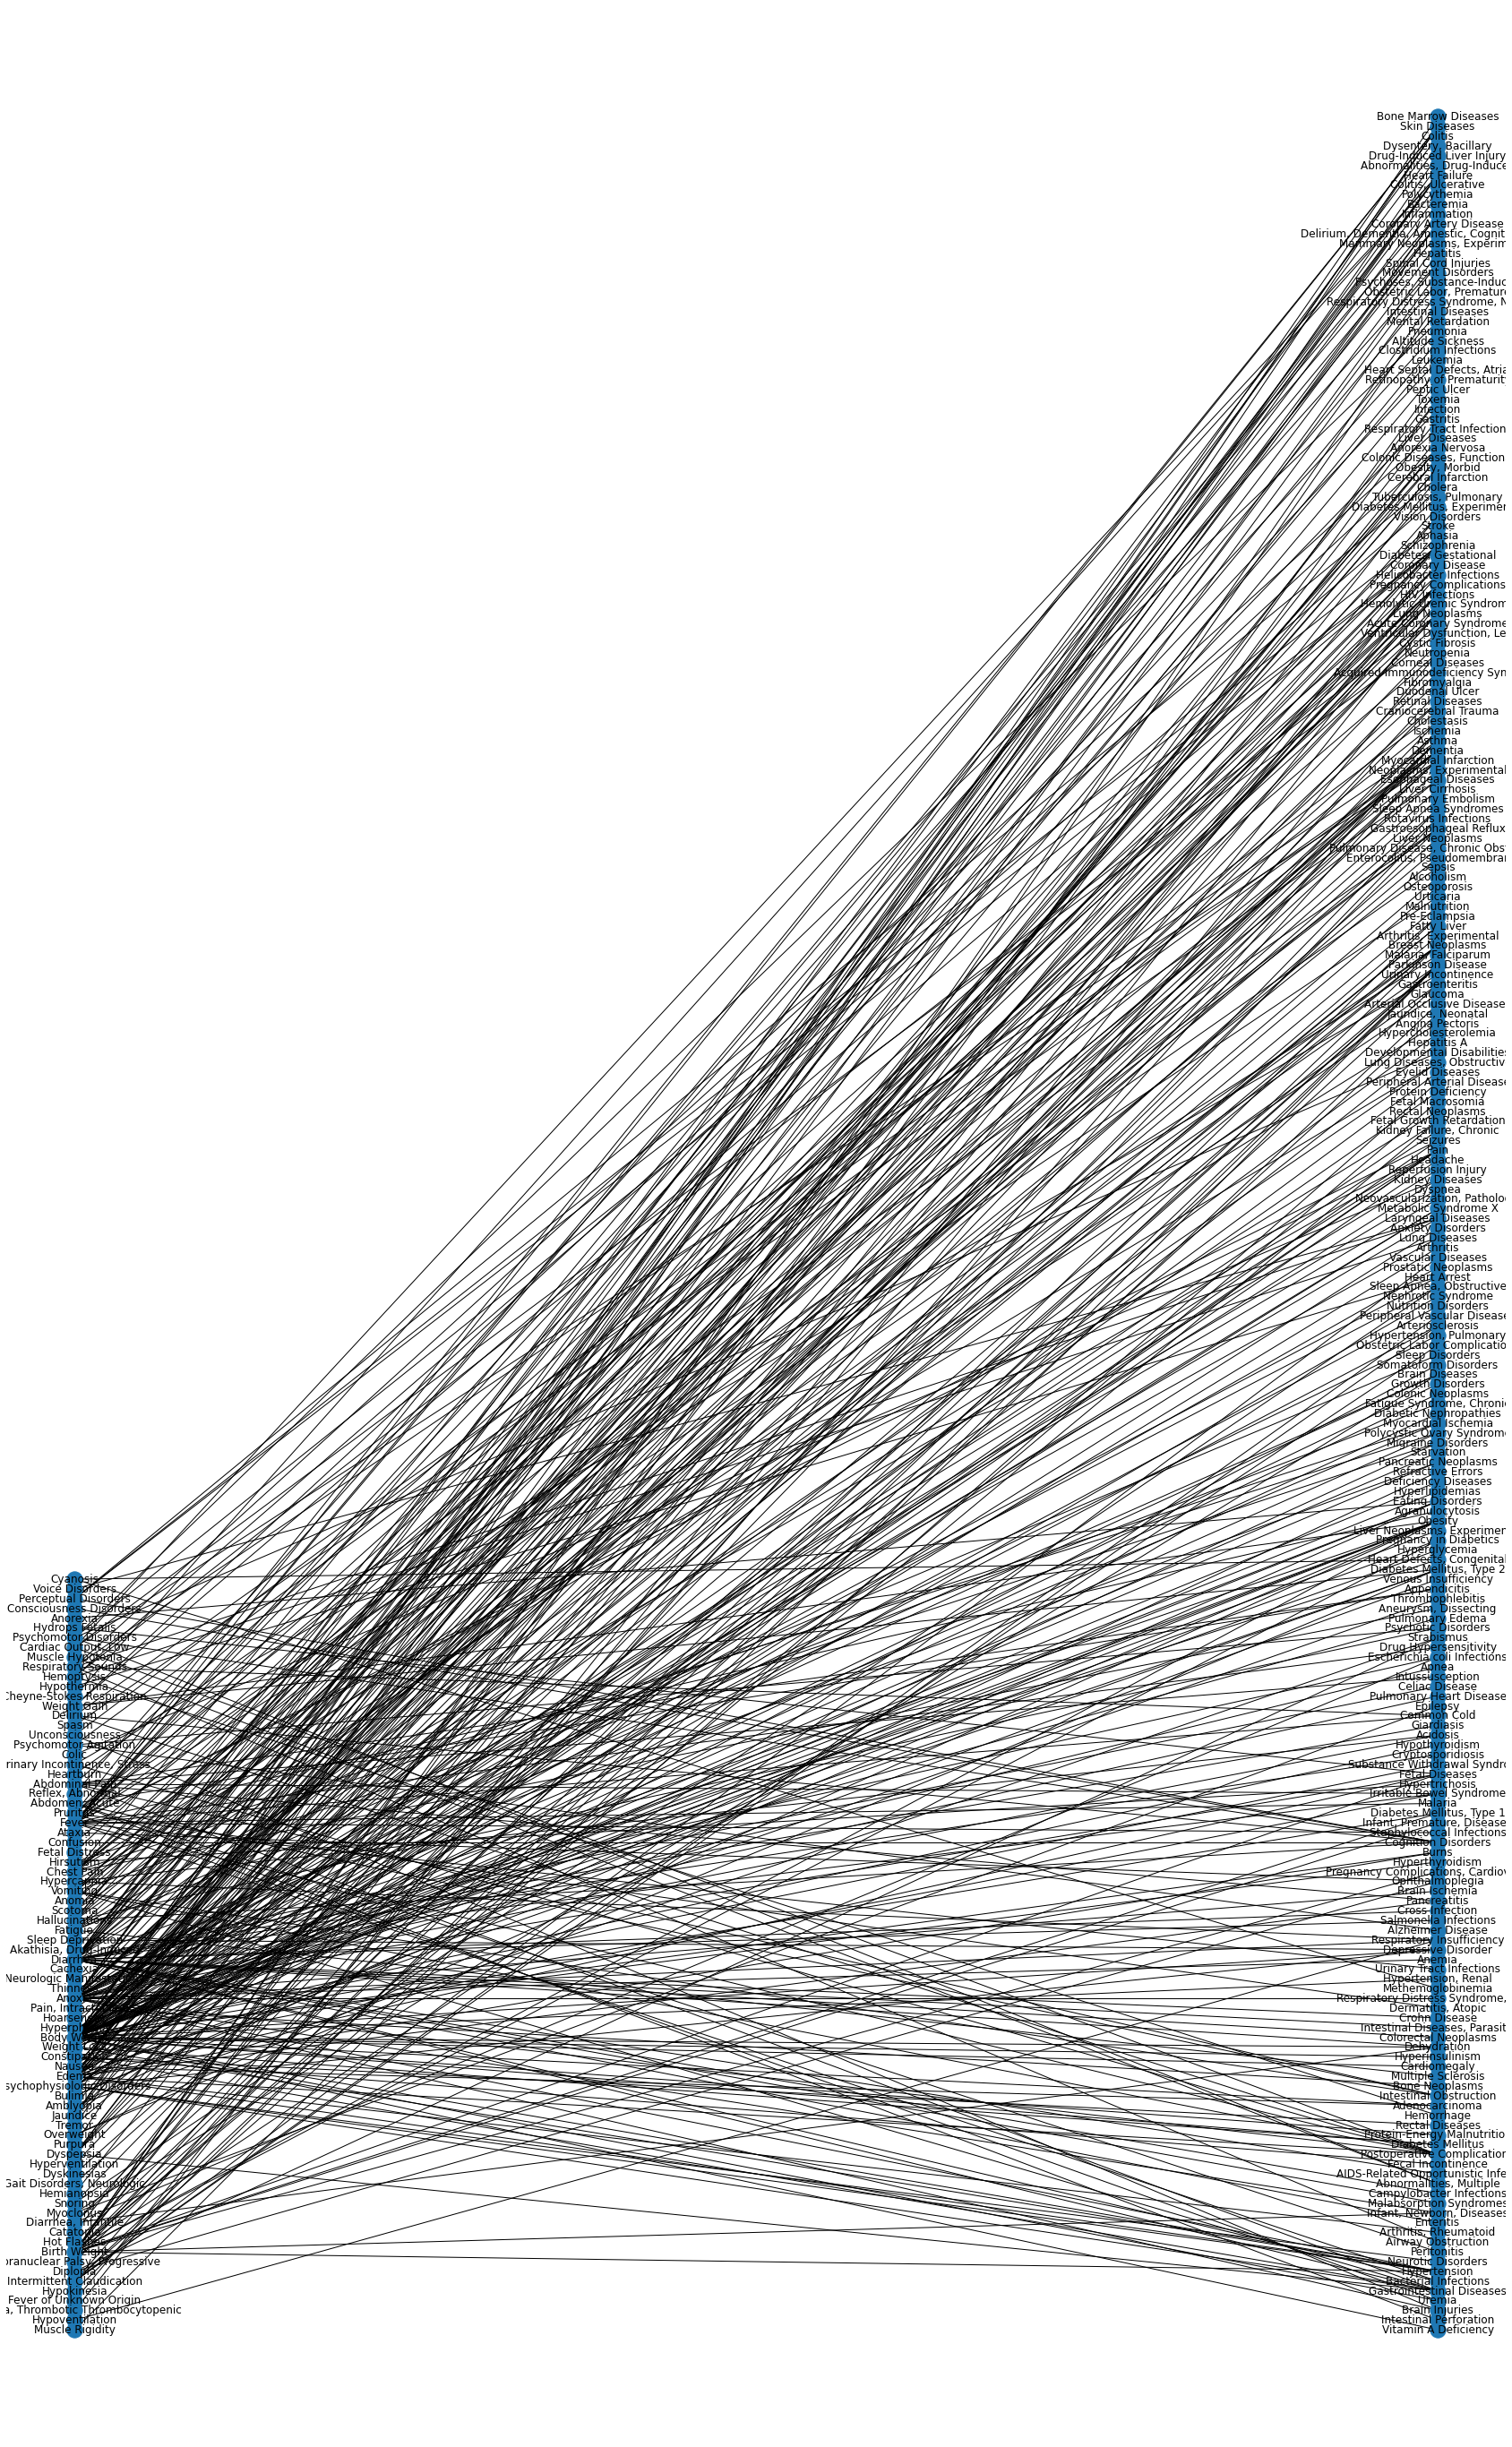

In [26]:
fig = plt.figure(figsize = (30, 50))
ax = fig.add_subplot(111)
ax.axis('off')

symptomNodes, diseaseNodes = bipartite.sets(GHSDNBipartiteII)
partition = dict()
partition.update((n, (1, i)) for i, n in enumerate(symptomNodes)) # put nodes from N1
partition.update((n, (2, i)) for i, n in enumerate(diseaseNodes)) # put nodes from N2
nx.draw(GHSDNBipartiteII, pos = partition, with_labels = True)
plt.show()

# Visualize Symptom/Disease Subgraphs

In [27]:
symptomSubgraph = bipartite.projected_graph(GHSDNBipartiteII, symptomNodes, multigraph=False)
diseaseSubgraph = bipartite.projected_graph(GHSDNBipartiteII, diseaseNodes, multigraph=False)

print(nx.info(symptomSubgraph))
print(nx.info(diseaseSubgraph))

Name: 
Type: Graph
Number of nodes: 78
Number of edges: 252
Average degree:   6.4615
Name: 
Type: Graph
Number of nodes: 228
Number of edges: 3877
Average degree:  34.0088


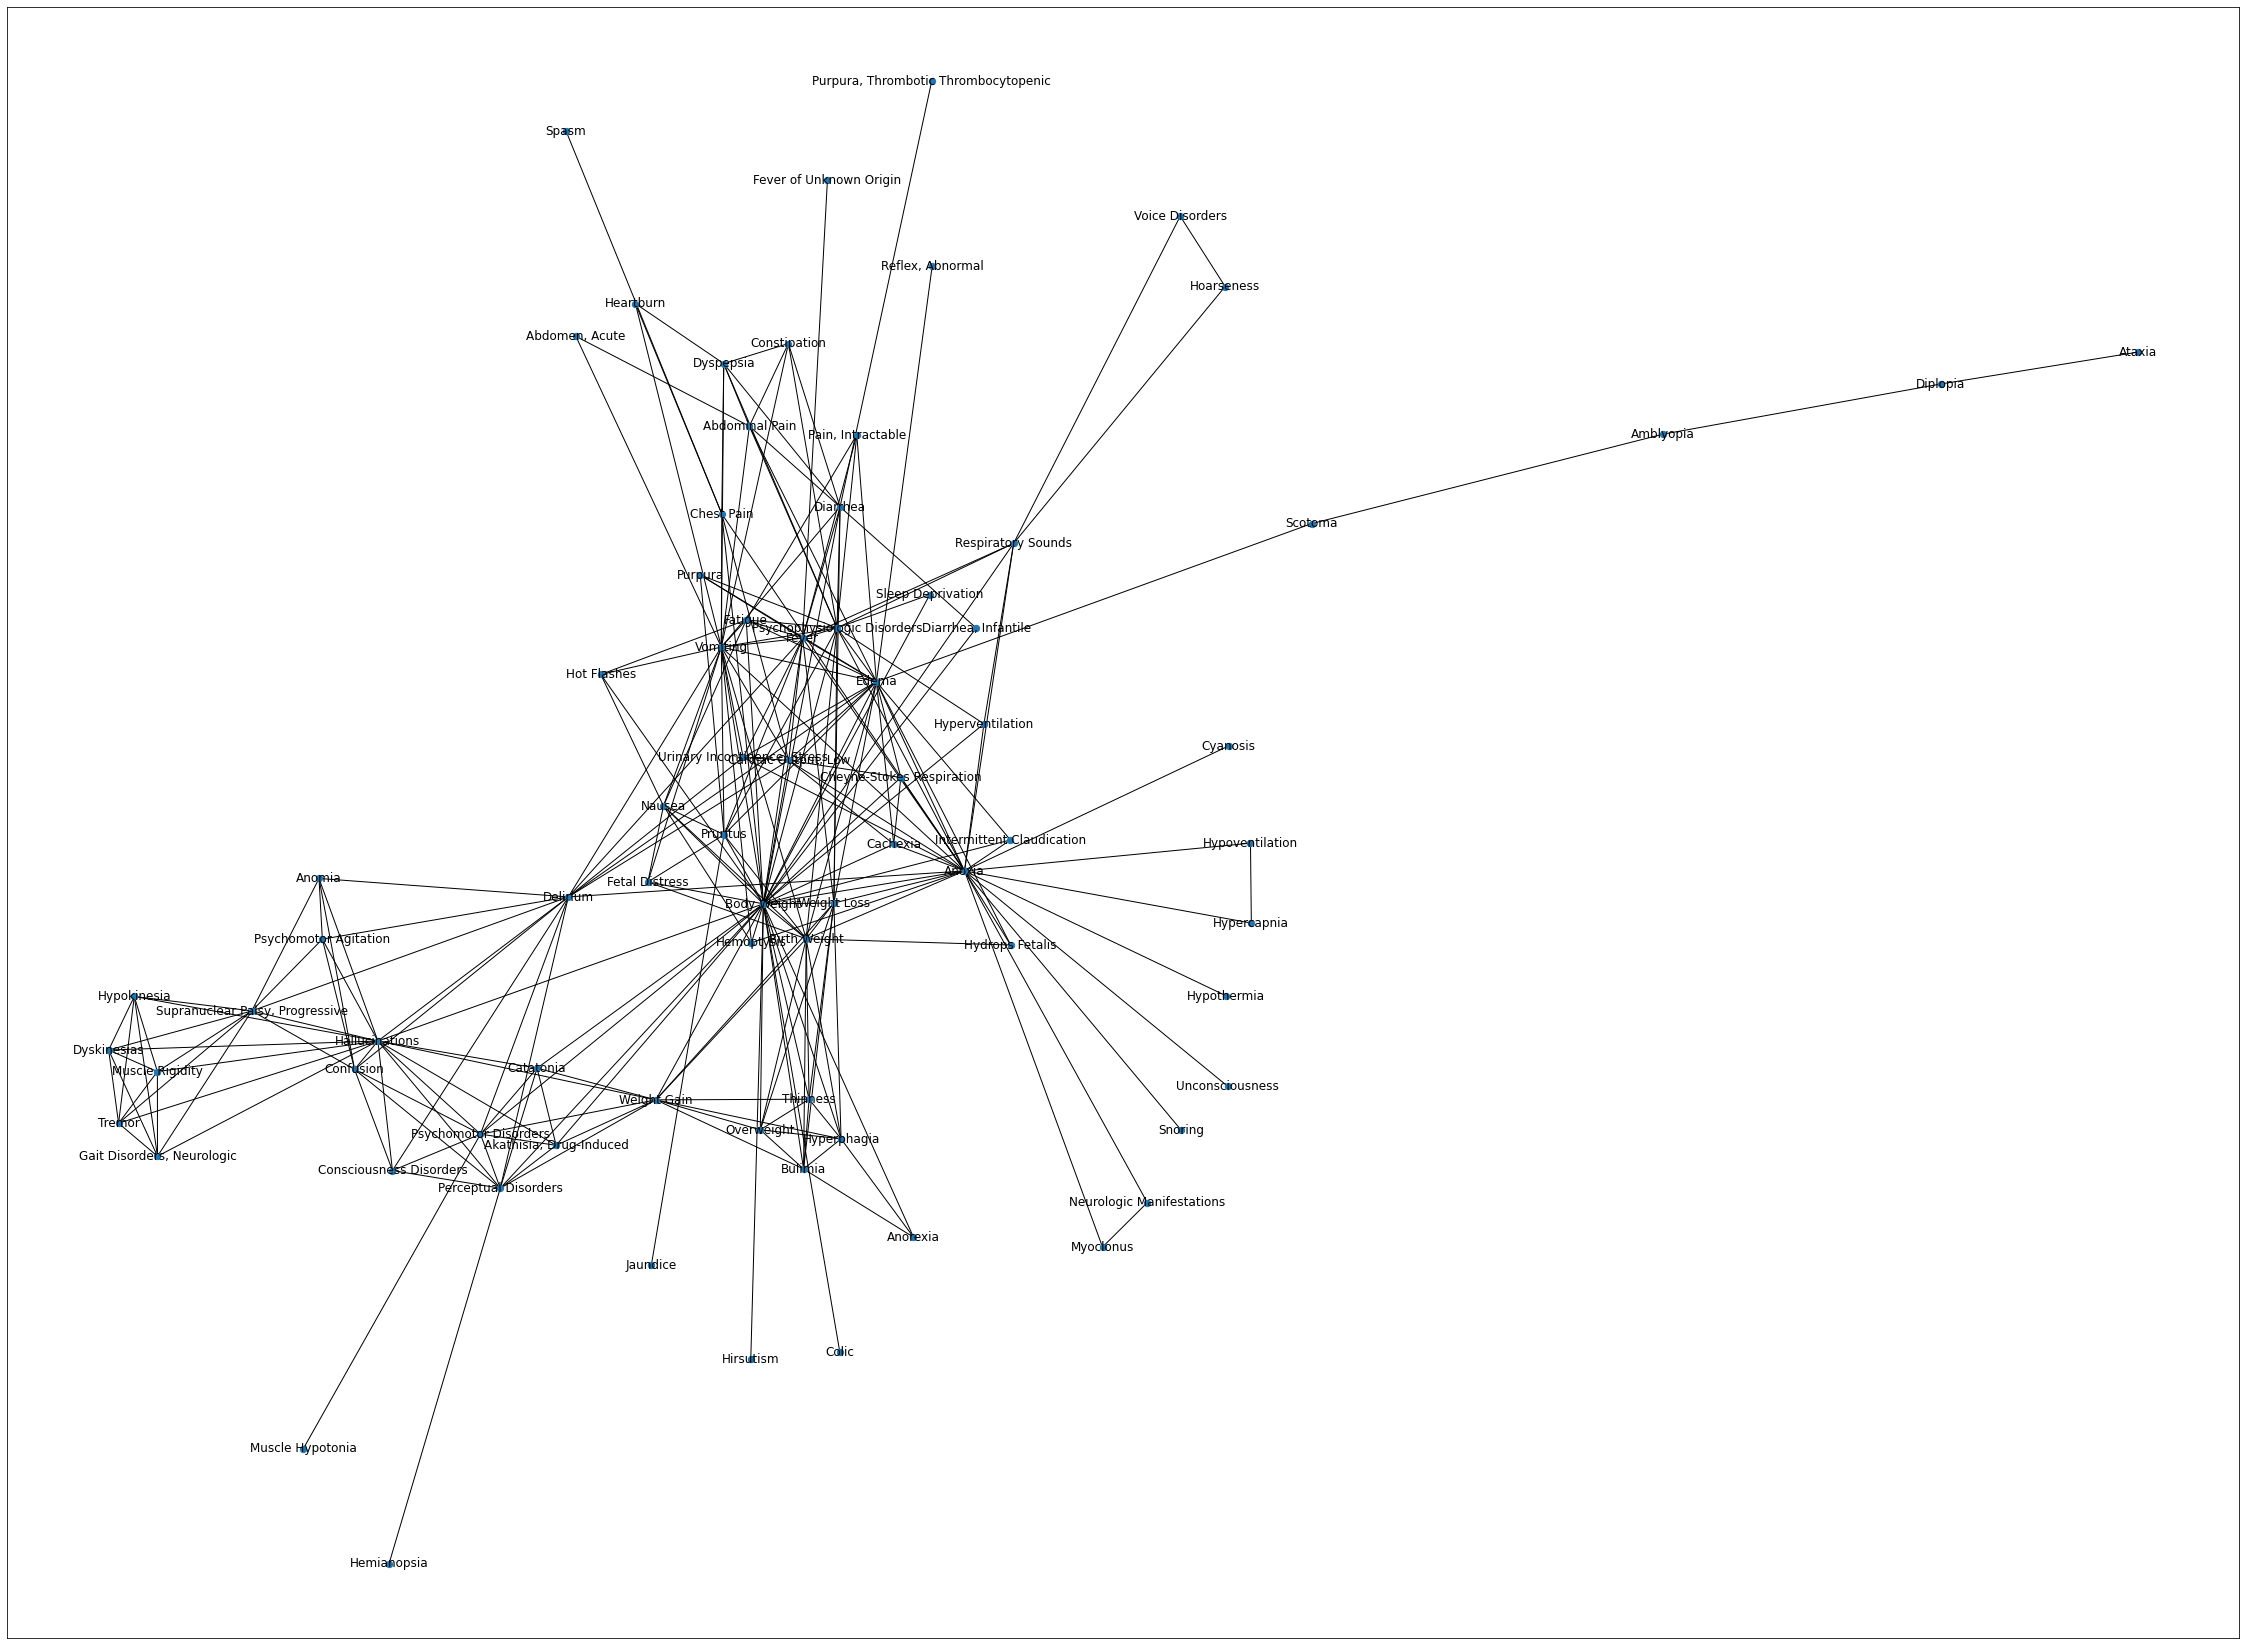

In [28]:
symptom_spring_pos = nx.spring_layout(symptomSubgraph)
fig, ax = plt.subplots(figsize = (40, 30))

node_size_default = 40

n = nx.draw_networkx(symptomSubgraph, symptom_spring_pos, ax = ax, node_size = node_size_default, with_labels = True)
plt.show()

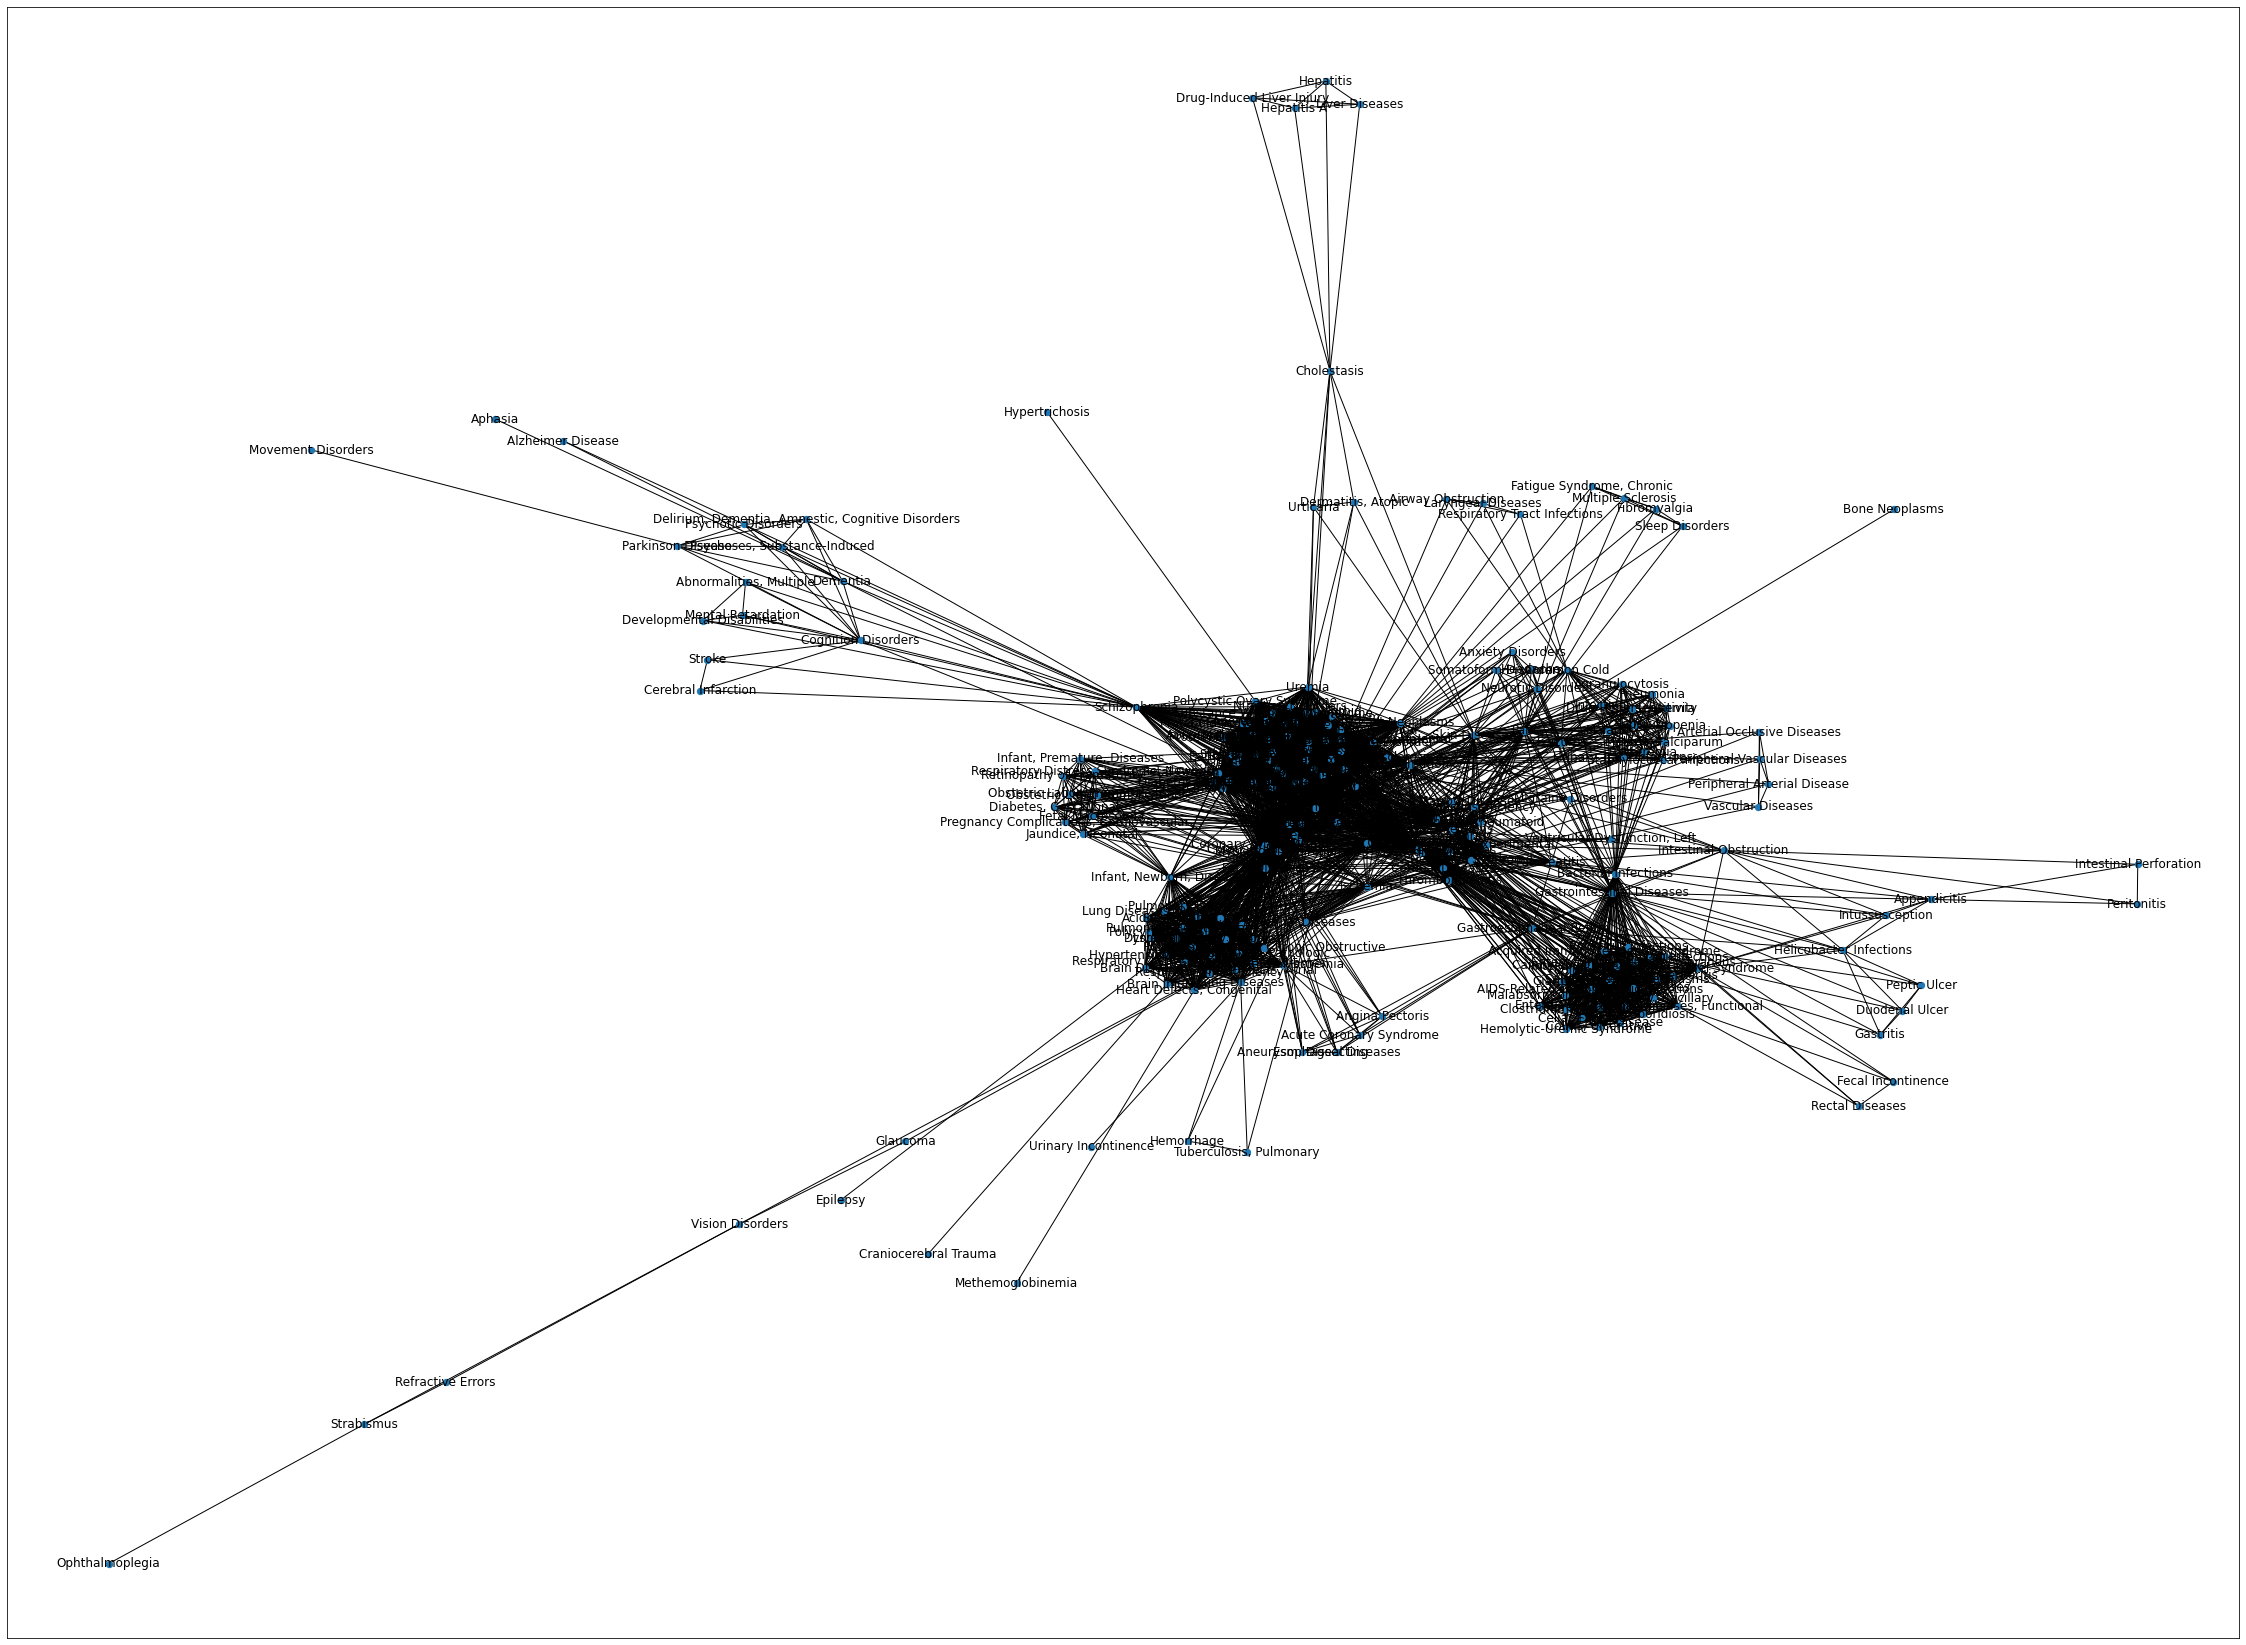

In [29]:
disease_spring_pos = nx.spring_layout(diseaseSubgraph)
fig, ax = plt.subplots(figsize = (40, 30))

node_size_default = 40

n = nx.draw_networkx(diseaseSubgraph, disease_spring_pos, ax = ax, node_size = node_size_default, with_labels = True)
plt.show()

# Symptom Degree Analysis

In [30]:
symptomNodes = symptomSubgraph.nodes()
degreeSymptom = [i[1] for i in symptomSubgraph.degree()]

symptomNodesOrdered = [j for i, j in sorted(zip(degreeSymptom, symptomNodes), reverse=True)]

print("Top 10 sorted symtom nodes: ", symptomNodesOrdered[:10])
print("")
print("Top 10 sorted symptom degrees: ", sorted(degreeSymptom[:10], reverse = True))
print("")
print("Bottom 10 sorted symtom nodes: ", symptomNodesOrdered[-10:])
print("")
print("Bottom 10 sorted symptom degrees: ", sorted(degreeSymptom[-10:], reverse = True))

Top 10 sorted symtom nodes:  ['Body Weight', 'Anoxia', 'Vomiting', 'Edema', 'Psychophysiologic Disorders', 'Hallucinations', 'Fever', 'Birth Weight', 'Delirium', 'Weight Loss']

Top 10 sorted symptom degrees:  [15, 10, 6, 6, 4, 3, 2, 2, 1, 1]

Bottom 10 sorted symtom nodes:  ['Purpura, Thrombotic Thrombocytopenic', 'Muscle Hypotonia', 'Jaundice', 'Hypothermia', 'Hirsutism', 'Hemianopsia', 'Fever of Unknown Origin', 'Cyanosis', 'Colic', 'Ataxia']

Bottom 10 sorted symptom degrees:  [10, 10, 10, 7, 5, 3, 3, 2, 1, 1]


(array([35., 21., 11.,  3.,  4.,  1.,  1.,  1.,  0.,  1.]),
 array([ 1. ,  4.5,  8. , 11.5, 15. , 18.5, 22. , 25.5, 29. , 32.5, 36. ]),
 <BarContainer object of 10 artists>)

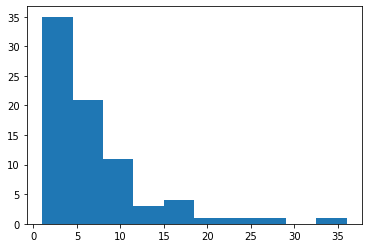

In [31]:
plt.hist(degreeSymptom)

# Disease Degree Analysis

In [32]:
diseaseNodes = diseaseSubgraph.nodes()
degreeDisease = [i[1] for i in diseaseSubgraph.degree()]

diseaseNodesOrdered = [j for i, j in sorted(zip(degreeDisease, diseaseNodes), reverse=True)]

print("Top 10 sorted symtom nodes: ", diseaseNodesOrdered[:10])
print("")
print("Top 10 sorted symptom degrees: ", sorted(degreeDisease[:10], reverse = True))
print("")
print("Bottom 10 sorted symtom nodes: ", diseaseNodesOrdered[-10:])
print("")
print("Bottom 10 sorted symptom degrees: ", sorted(degreeDisease[-10:], reverse = True))

Top 10 sorted symtom nodes:  ['Hypertension', 'Heart Failure', 'HIV Infections', 'Asthma', 'Myocardial Infarction', 'Coronary Disease', 'Coronary Artery Disease', 'Inflammation', 'Pancreatic Neoplasms', 'Dehydration']

Top 10 sorted symptom degrees:  [123, 65, 61, 57, 49, 37, 10, 4, 3, 3]

Bottom 10 sorted symtom nodes:  ['Alzheimer Disease', 'Urinary Incontinence', 'Ophthalmoplegia', 'Movement Disorders', 'Methemoglobinemia', 'Hypertrichosis', 'Epilepsy', 'Craniocerebral Trauma', 'Bone Neoplasms', 'Aphasia']

Bottom 10 sorted symptom degrees:  [109, 61, 50, 36, 31, 31, 31, 22, 19, 4]


(array([65., 35., 55.,  4., 43., 13.,  3.,  6.,  3.,  1.]),
 array([  1. ,  13.2,  25.4,  37.6,  49.8,  62. ,  74.2,  86.4,  98.6,
        110.8, 123. ]),
 <BarContainer object of 10 artists>)

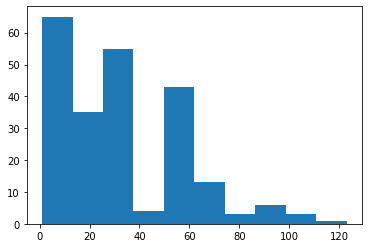

In [33]:
plt.hist(degreeDisease)

# Community Detection (Louvain Algorithms)

Symptom communities:  5


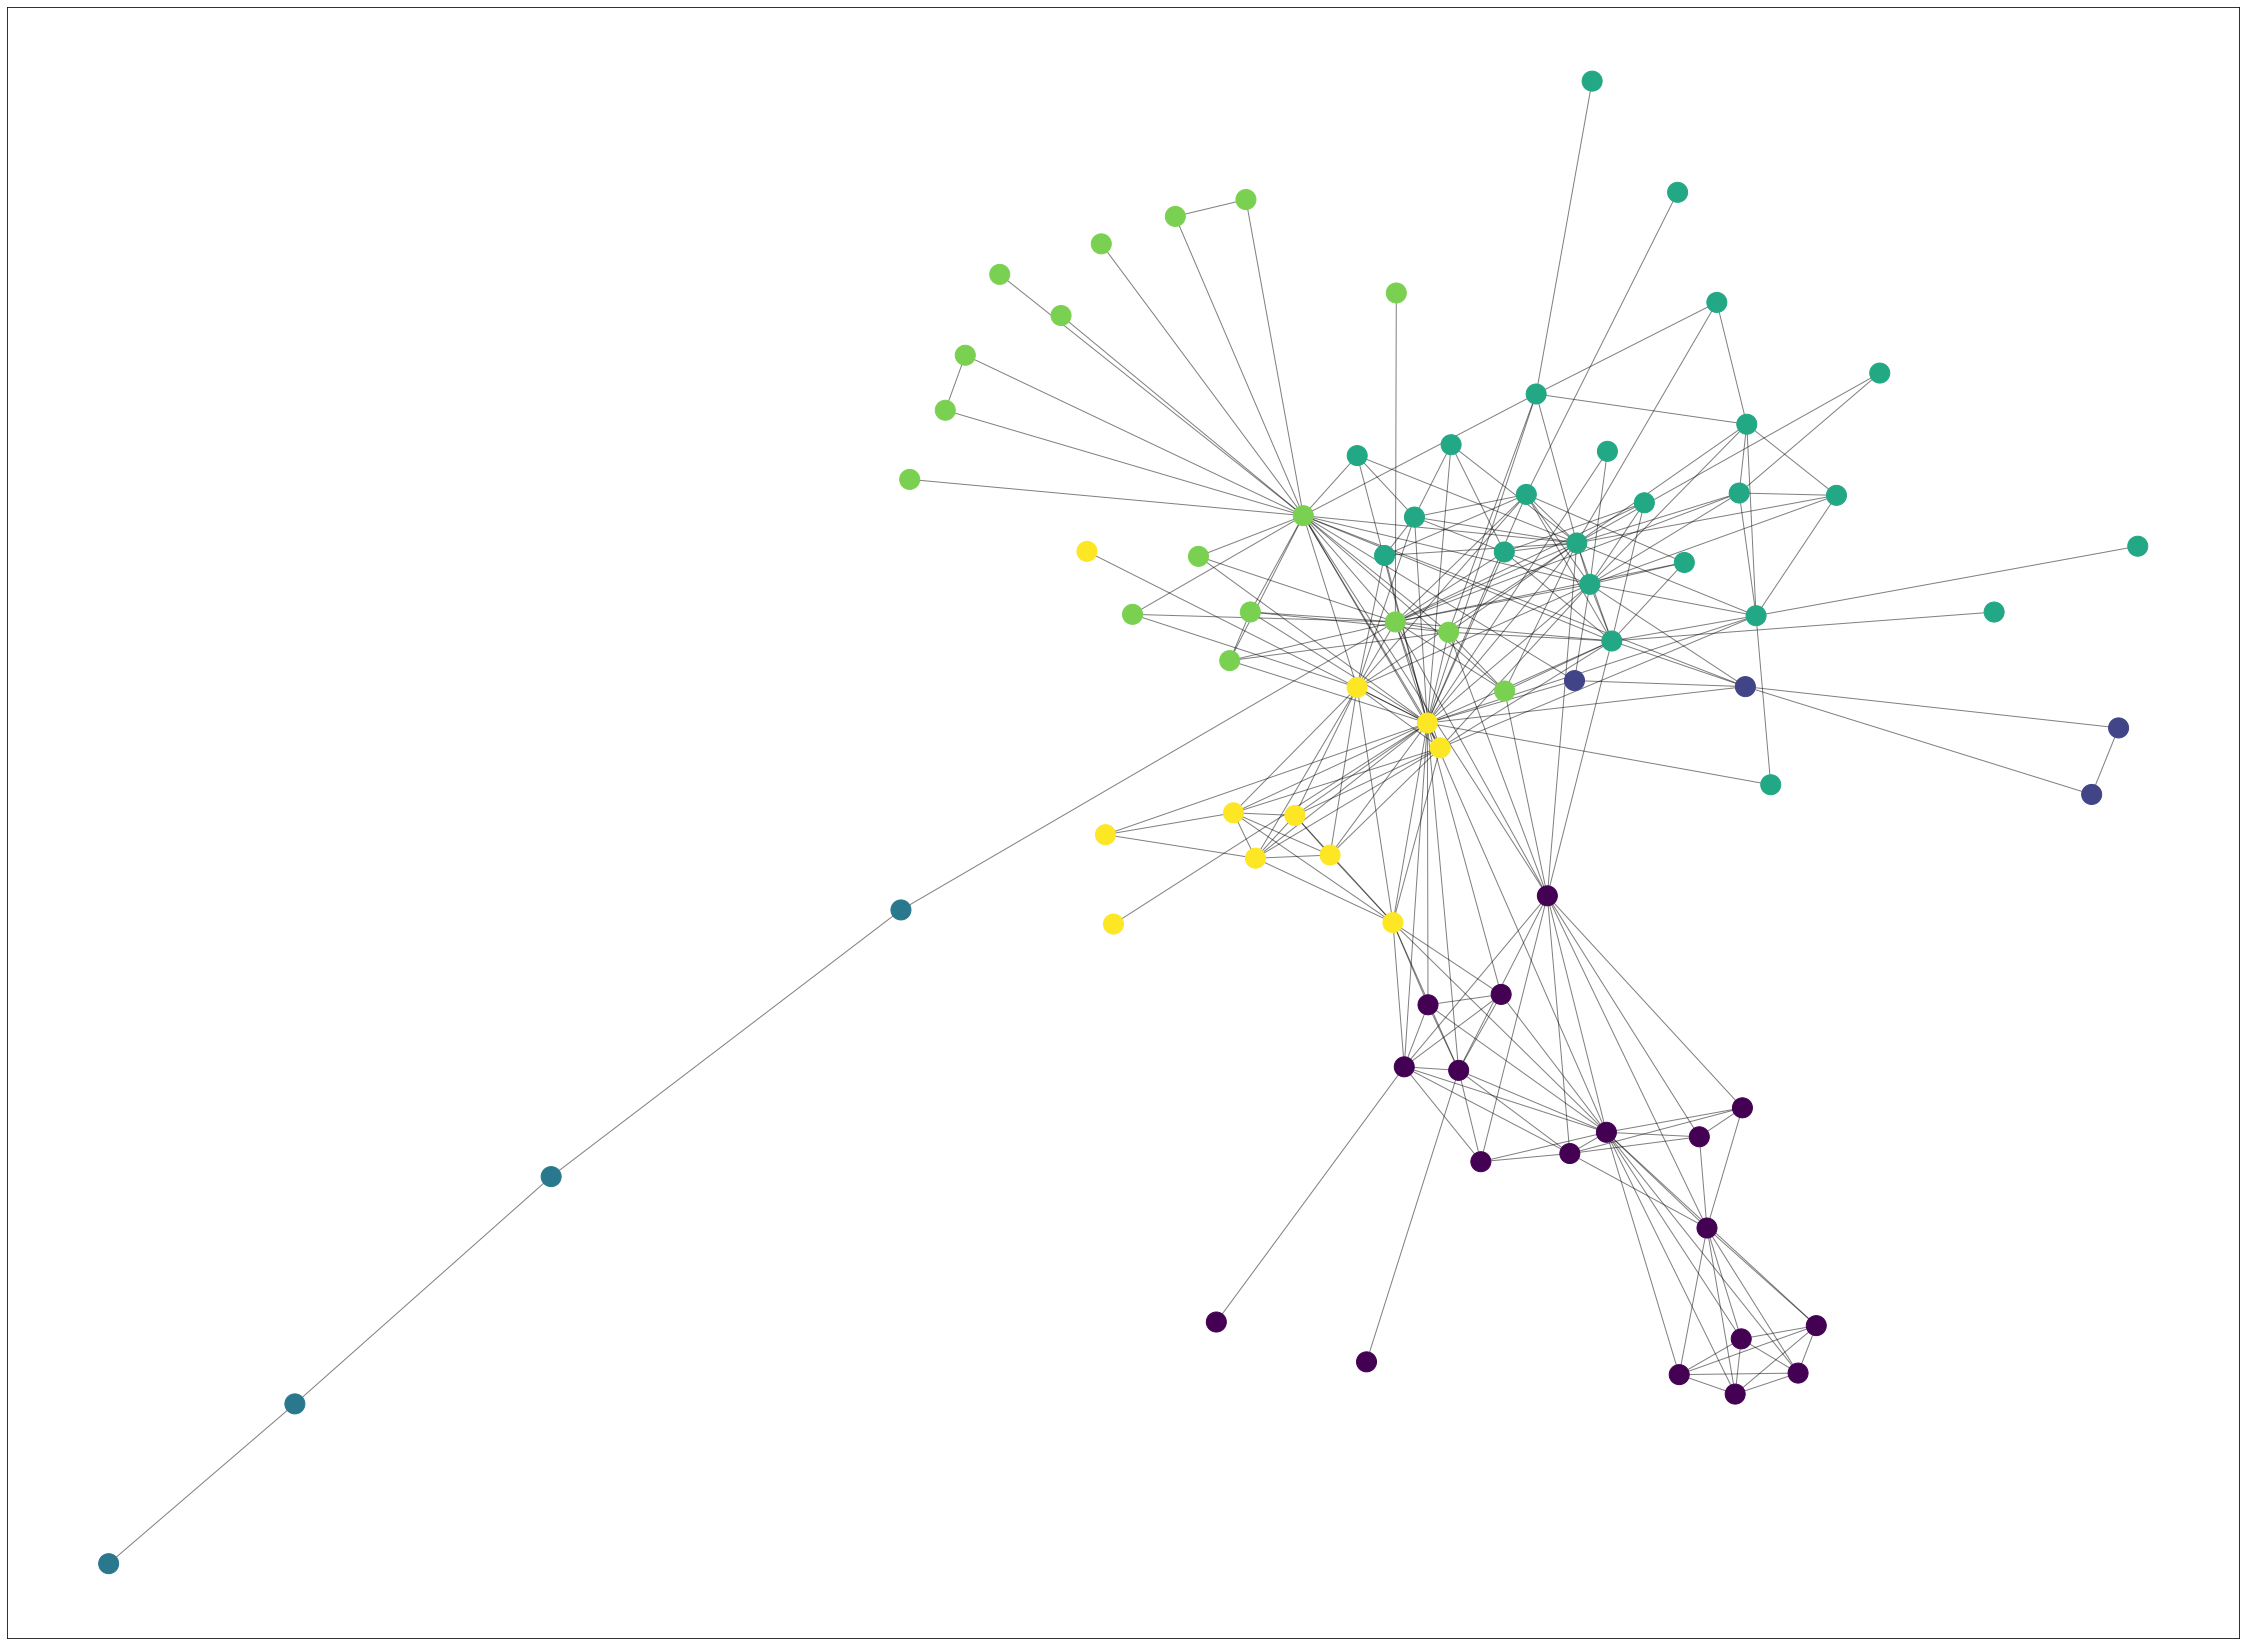

In [59]:
# Symptom subgraph

fig, ax = plt.subplots(figsize = (40, 30))

louvainSymptomClusteringParition = community_louvain.best_partition(symptomSubgraph)
communitiesSymptoms = [louvainSymptomClusteringParition.get(node) for node in symptomSubgraph.nodes()]
print("Symptom communities: ", max(communitiesSymptoms))

symptomSpringLayout = nx.spring_layout(symptomSubgraph)
cmap = cm.get_cmap('viridis', max(louvainSymptomClusteringParition.values()) + 1)

nx.draw_networkx_nodes(symptomSubgraph, symptomSpringLayout, louvainSymptomClusteringParition.keys(), node_size=400, cmap=cmap, node_color=list(louvainSymptomClusteringParition.values()))

nx.draw_networkx_edges(symptomSubgraph, symptomSpringLayout, alpha=0.5)
plt.show()

Disease communities:  7


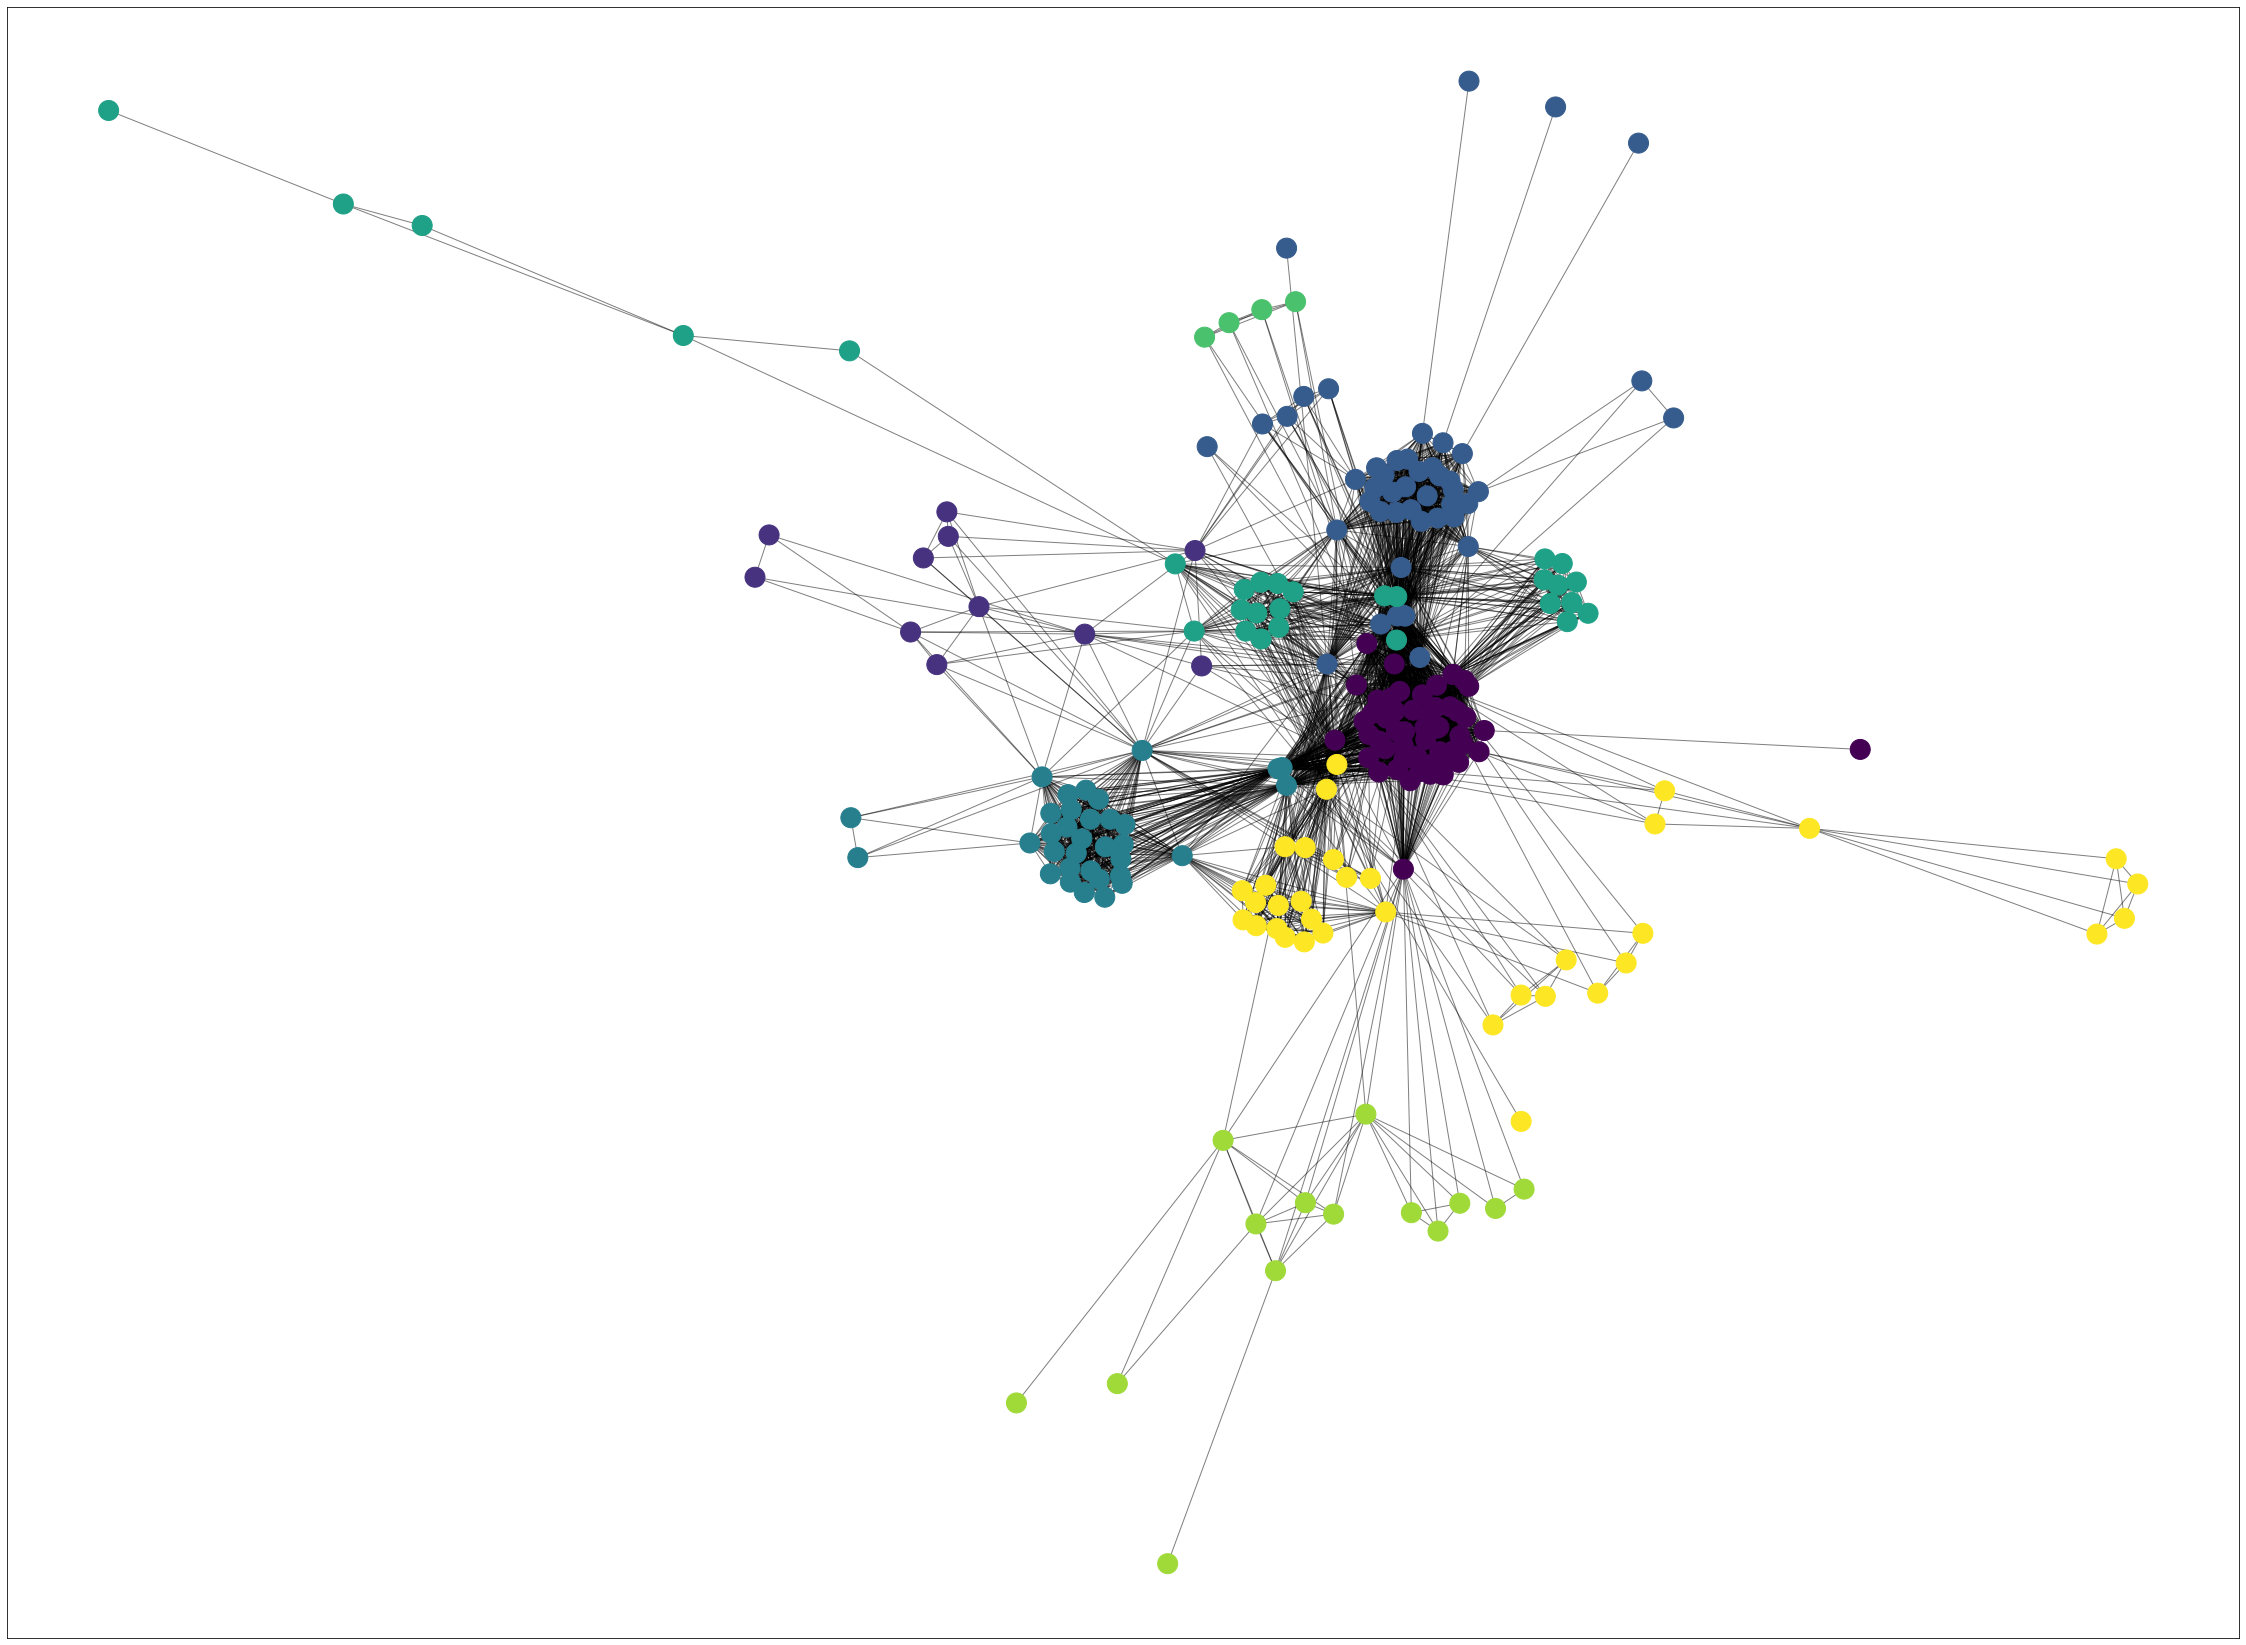

In [57]:
# Disease subgraph

fig, ax = plt.subplots(figsize = (40, 30))

louvainDiseaseClusteringParition = community_louvain.best_partition(diseaseSubgraph)
communitiesDisease = [louvainDiseaseClusteringParition.get(node) for node in diseaseSubgraph.nodes()]
print("Disease communities: ", max(communitiesDisease))

diseaseSpringLayout = nx.spring_layout(diseaseSubgraph)
cmap = cm.get_cmap('viridis', max(louvainDiseaseClusteringParition.values()) + 1)

nx.draw_networkx_nodes(diseaseSubgraph, diseaseSpringLayout, louvainDiseaseClusteringParition.keys(), node_size=400, cmap=cmap, node_color=list(louvainDiseaseClusteringParition.values()))

nx.draw_networkx_edges(diseaseSubgraph, diseaseSpringLayout, alpha=0.5)
plt.show()

# Community Insights

In [ ]:
asdf

# Bipartite DC-SBM, more recent Larremore paper on block models

In [ ]:
# Kernighan-Lin inference 

kl = KL(f_engine="engines/bipartiteSBM-KL/biSBM",
        n_sweeps=2,                                        # Note that this will generate <n_sweeps> output sub-folders in <f_kl_output>
        is_parallel=False,
        n_cores=2,
        kl_edgelist_delimiter="\t",                        # [KL] due to the KL code accepts 1-indexed nodes by default, we used the delimiter to transform our 0-indexed input.
        kl_steps=4,                                        # [KL] the number of random initializations (see the README_cplusplus.txt file)
        kl_itertimes=1,                                    # [KL] the number of KL runs (within each <outputFOLDER>) for returning an optimal result
        f_kl_output="engines/bipartiteSBM-KL/f_kl_output"  # [KL] path to the KL output dir; recommended to be in the same folder as the binary
    )

kl.prepare_engine("dataset/test/bisbm-n_1000-ka_4-kb_6.edgelist", 500, 500, 6, 7, delimiter="\t")

edgelist = get_edgelist("dataset/test/bisbm-n_1000-ka_4-kb_6.edgelist", "\t")
types = kl.gen_types(500, 500)

oks = OptimalKs(kl, edgelist, types)
oks.set_params(init_ka=10, init_kb=10, i_0=0.1)
oks.minimize_bisbm_dl()

print(oks.bookkeeping_mb["mcmc"][(4, 6)])

In [ ]:
# MCMC inference
n1 = 18
n2 = 14

mcmc = MCMC(f_engine="engines/bipartiteSBM-MCMC/bin/mcmc")

mcmc.prepare_engine("dataset/test/southernWomen.edgelist", 18, 14, 3, 2)
# Out[*]: 'engines/bipartiteSBM-MCMC/bin/mcmc -e dataset/test/southernWomen.edgelist -n 6 6 6 7 7 -t 1000000 -x 100000 -c abrupt_cool -a 100000.0 -y 18 14 -z 3 2 -E 0.001 -g

edgelist = get_edgelist("dataset/test/southernWomen.edgelist")
types = get_types("dataset/test/southernWomen.types")

types = mcmc.gen_types(n1, n2)  # n1=18 & n2=14

oks = OptimalKs(mcmc, edgelist, types)

oks.minimize_bisbm_dl()
# Out[*]:
# OrderedDict([((1, 1), 191.72536162138402),
#              ((6, 7), 227.47573446636372),
#              ((2, 1), 199.25454713207995),
#              ((1, 2), 197.11255878689138),
#              ((1, 3), 202.30070134785217),
#              ((2, 2), 199.5005556514051),
#              ((2, 3), 196.01966191156208),
#              ((3, 1), 203.69566837215007),
#              ((3, 2), 204.73016933010257),
#              ((3, 3), 201.34320240110824)])

oks.summary()
# Out[*]:
# {'algm_args': {'init_ka': 6, 'init_kb': 7, 'i_0': 0.058872511354072427},
#  'na': 18,
#  'nb': 14,
#  'e': 89,
#  'avg_k': 5.5625,
#  'ka': 1,
#  'kb': 1,
#  'mdl': 191.72536162138402,
#  'dl': {'adjacency': 108.99607644928233,
#   'partition': 5.5294290875114225,
#   'degree': 77.19985608459028,
#   'edges': 0.0}}

# Alternate Network Creation

In [ ]:
# Create network

Ghsdn = nx.from_pandas_edgelist(dfHSDN, 'MeSH Disease Term', 'MeSH Symptom Term', edge_key="TFIDF score",)

n = Ghsdn.number_of_nodes()
m = Ghsdn.number_of_edges()

print(f'number of nodes, n  = {n}')
print(f'number of edges, m  = {m}') # 4802 missing edges?

In [ ]:
#with_labels = 'True'
# plt.figure(figsize = (12, 6)) # Define new figure size because default figure produced turned out to be too smal
# hsdnLayoutGraph = nx.draw_spring(Ghsdn, with_labels = 'True', node_size = 500, font_color = 'black', node_color = 'blue') # Use nx.draw_spring to draw graph in spring layout. Use white on blue color scheme
# plt.show() # Show the layout itself after graph has been built

uniqueSymptom = sum(dfHSDN["MeSH Symptom Term"].value_counts())
print(uniqueSymptom)

print()

uniqueSymptomLabels = dfHSDN["MeSH Symptom Term"].unique()
print(uniqueSymptomLabels)

print()

uniqueDiseaseLabels = dfHSDN["MeSH Disease Term"].unique()
print(uniqueDiseaseLabels)
print(len(uniqueDiseaseLabels))
print(len(uniqueSymptomLabels))

In [ ]:
nx.is_connected(Ghsdn)
print(nx.number_connected_components(Ghsdn))
print(nx.node_connected_component(Ghsdn, 'Aging, Premature'))
print([len(c) for c in sorted(nx.connected_components(Ghsdn), key=len, reverse=True)])

In [ ]:
# Remove extraneous connected component

for component in list(nx.connected_components(Ghsdn)):
    if len(component) < 3:
        for node in component:
            Ghsdn.remove_node(node)

In [ ]:
# Calculate summary statistics. Network is disconnected it seems like so should we instead to edge prediction?

diameter = nx.diameter(Ghsdn)
ellmean = compute_MGD(Ghsdn)
C = nx.transitivity(Ghsdn) 
h = nx.number_connected_components(Ghsdn)
degrees = [i[1] for i in Ghsdn.degree()]
kmax = max(degrees)
kstd = np.std(degrees)

plot_CCDF(degrees) # Call plot_CCDF on degrees list

print(f'diameter = {diameter}')
print(f'mean geodesic distance, <ell> = %5.2f' % ellmean)
print(f'clustering coefficient, C     = %5.2f' % C)
print(f'number of components,   h     =  {h}')
print(f'max degree, k_max = {kmax}')
print(f'max degree, k_std = %5.2f' % kstd)